#Read me

このフィールをcolabで開くと読みやすくなります。
またcolabでは直接に実行できます。

GinzaのA,B,C三つのモードでそれぞれに形態素解析を行う時に、メモリが結構かかりますので(8GB以上)、ご注意ください。(colabではruntimeの設定でchange runtime typeでHigh-RAMに変更することはできます)
また、cpuでGinzaを実行するに半時間以上かかる可能性がありますので、これもご注意ください。精度では、cpuとgpuの差別がありません。

（１）MeCab Janome Ginza SudachiPyその比較分析の説明を入れ、htmlファイル形式にして欲しいです。
  
　　2.5時間比較のところにご確認ください。

　　実行したい場合は0.,1.,2.を順番に実行してください。Janomeとginzaは一回実行ごとにおよそ10分がかかります。
   

（２）それぞれの形態素解析のMeCab、bjanome、Ginza（Aモード、Bモード、C-モード）、
SudachiPya（Aモード、Bモード、C-モード）8種類の結果から名詞を抽出し、9カテゴリの判別分析を行い精度を比較してください。次のページをのようにhtmlページを作成してください。分類器はRFとSVMの2種類を用いてください。

　　4.精度比較のところにご確認ください。

　　実行したい場合は0.,1.,2.,4.を順番に実行してください


#0.パッケージ＆環境

##0.1パッケージ

In [1]:
#必要のパッケージをインストールする
#インストールには数分がかかる
!pip install -U ginza ja-ginza
!pip install mecab-python3
!pip install unidic-lite
!pip install janome
!pip install sudachipy sudachidict_full #ここはfullで、他にsudachidict_coreやsudachidict_smallも
!pip install nlplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 98.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for SudachiDict-core: filename=SudachiDict_core-20230110-py3-none-any.whl size=71665396 sha256=7e45e8229bd40474dc5befd7fb36aea57acb0a62f315875bc5d8e175dc50b069
  Stored in directory: /root/.cache/pip/wheels/53/fb/7b/5a2f84cba933a120cefe3587a01ed20dbc9a033a6bb43672e7
Successfully built SudachiDict-core
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.8/577.8 KB 11.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 32.7 MB/s eta 0:00:00
  Preparing metadata 

In [2]:
#共用のパッケージを導入
from tqdm.auto import tqdm    
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
#このページで用いるパッケージのバージョンを示す
!pip freeze|grep -i -E "ginza|mecab|janome|sudachipy|spacy|plot|gensim|sklearn"   

en-core-web-sm @ https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.4.1/en_core_web_sm-3.4.1-py3-none-any.whl
gensim==3.6.0
ginza==5.1.2
ja-ginza==5.1.2
Janome==0.4.2
matplotlib==3.2.2
matplotlib-venn==0.11.7
mecab-python3==1.0.6
nlplot==1.6.0
plotly==5.5.0
plotnine==0.8.0
sklearn-pandas==1.8.0
spacy==3.4.4
spacy-legacy==3.0.11
spacy-loggers==1.0.4
SudachiPy==0.6.6


##0.2環境

In [4]:
#ここのcpu family:6とmodel:79はBroadwell(server)を意味する。Intel CPU Broadwell-EP Xeon E5-2630v4かも
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 2
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs mmio_stale_data retbleed
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtua

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jan 20 08:44:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
#py version
!python -V 

Python 3.8.10


#1.テキスト導入、処理

In [7]:
import os
import re

In [8]:
!curl -O https://rondhuit.com/download/ldcc-20140209.tar.gz
!tar zxf ldcc-20140209.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 8647k  100 8647k    0     0  1468k      0  0:00:05  0:00:05 --:--:-- 1886k


In [9]:
%cd /content/text

/content/text


In [10]:
!ls

CHANGES.txt	kaden-channel	peachy	    sports-watch
dokujo-tsushin	livedoor-homme	README.txt  topic-news
it-life-hack	movie-enter	smax


In [11]:
get_dir_list = lambda path=os.getcwd():[i for i in os.listdir(path) if i not in ('README.txt','CHANGES.txt','LICENSE.txt')]

In [12]:
catagory = get_dir_list()

catagory

['sports-watch',
 'livedoor-homme',
 'it-life-hack',
 'kaden-channel',
 'dokujo-tsushin',
 'smax',
 'movie-enter',
 'peachy',
 'topic-news']

In [13]:
catagory_mapping = {}
for i in range(len(catagory)):
    catagory_mapping[catagory[i]] = i
catagory_mapping

{'sports-watch': 0,
 'livedoor-homme': 1,
 'it-life-hack': 2,
 'kaden-channel': 3,
 'dokujo-tsushin': 4,
 'smax': 5,
 'movie-enter': 6,
 'peachy': 7,
 'topic-news': 8}

In [14]:
text_dir_list = {}
for i in catagory:
    text_dir_list[i] = get_dir_list(i) #'\\text'

In [15]:
text_dir_list['topic-news'][:10]

['topic-news-6166579.txt',
 'topic-news-6244405.txt',
 'topic-news-6617400.txt',
 'topic-news-6281211.txt',
 'topic-news-6746151.txt',
 'topic-news-6679555.txt',
 'topic-news-6241971.txt',
 'topic-news-6418897.txt',
 'topic-news-6275934.txt',
 'topic-news-6636116.txt']

In [16]:
%%time
def get_text(path):
    with open(path,'r',encoding = 'utf-8') as fr:
        ret = fr.read()
    return ret

raw_text_list = {}
for i in catagory:
    raw_text_list[i] = [get_text(i+'/'+j) for j in tqdm(text_dir_list[i],desc = 'loading file in '+i)]

loading file in sports-watch:   0%|          | 0/900 [00:00<?, ?it/s]

loading file in livedoor-homme:   0%|          | 0/511 [00:00<?, ?it/s]

loading file in it-life-hack:   0%|          | 0/870 [00:00<?, ?it/s]

loading file in kaden-channel:   0%|          | 0/864 [00:00<?, ?it/s]

loading file in dokujo-tsushin:   0%|          | 0/870 [00:00<?, ?it/s]

loading file in smax:   0%|          | 0/870 [00:00<?, ?it/s]

loading file in movie-enter:   0%|          | 0/870 [00:00<?, ?it/s]

loading file in peachy:   0%|          | 0/842 [00:00<?, ?it/s]

loading file in topic-news:   0%|          | 0/770 [00:00<?, ?it/s]

CPU times: user 298 ms, sys: 126 ms, total: 424 ms
Wall time: 454 ms


In [17]:
raw_text_list['it-life-hack'][0]

'http://news.livedoor.com/article/detail/6864069/\n2012-08-17T17:00:00+0900\n心の中に音を感じたときに撮る！相星哲也 氏が語る、音を感じる風景【NEXT GENERATION】\n写真は現実の世界を映し出すが、そこには目で見えるものだけが写るとは限らない。\n\n東京・銀座にあるリコーフォトギャラリーRING CUBE 9Fフォトスペースにて2012年8月１日（水）〜8月13日（月）、に開催された相星哲也 氏の写真展「韻」もその一つだ。\n\n相星哲也 氏の写真展「韻」の作品の前に立つと、写るはずのなのない、音、リズムが聞こえるような体感ができるのだ。\n\n \n \n\nデジタルカメラが主流の時代に、あえてフィルムカメラ、それもモノクロ写真を選び、音が感じられる作品について、お話しを伺った。\n\n■ピンホールとモノクロ写真の2つの世界をもつ相星氏\n今回の写真展「韻」は、今年（2012年）1月、ヨコハマ フォトフェスティバル 2012「地域・写真・記憶」に出品した相星氏の作品がRING CUBE スタッフの目に留まったことから実現したという。\n\n声を掛けられてから締め切りまでの期間は短かったが、最近撮ったものの中から今回の「韻」の作品を用意したそうだ。\n\n相星氏は、今回のモノクロ写真のほかにも、ピンホールカメラの活動もしているという。\n日本針穴写真協会というピンホール写真を専門に扱った協会の会員でもある相星氏は、ピンホール写真で海外の公募展や国内のピンホール写真コンテストにも受賞している。\n\n「ピンホールの作品は海外では評判が良かったのですが、日本ではあまり良い評判はなくて、遊びの延長と評価されることが多かったです。」\n日本と海外での写真のスタンスの違いもあり、相星氏は、ピンホール以外の表現方法も模索したという。\n\n \nピンホールについて語る、相星哲也 氏 \n\nそして相星氏は、渡部さとる 氏のワークショップに参加、フィルムや現像、撮影方法など、写真についての知識を深めたそうだ。\n\n「渡部先生が白岡先生を薦めてくれたので、今でも通っていますが、そこでモノクロ写真の作品を創るようになりました。」\n\n今回の「韻」は、こうしてモノクロのフィルム作品として生まれ

In [18]:
text_list = {} 
remove_blank = lambda ls:[i for i in ls if i != '']
rs = 'https?://\S+|20[0-2]\d-\d\d-\d\dT\d\d:\d\d:\d\d\+\d{4,4}|【関連記事】|\u3000|■'

for i in catagory:
    text_list[i] = [remove_blank(re.split('\n',re.sub(rs,'',j))) for j in tqdm(raw_text_list[i],desc = 'preprocessing text in '+i) ]

preprocessing text in sports-watch:   0%|          | 0/900 [00:00<?, ?it/s]

preprocessing text in livedoor-homme:   0%|          | 0/511 [00:00<?, ?it/s]

preprocessing text in it-life-hack:   0%|          | 0/870 [00:00<?, ?it/s]

preprocessing text in kaden-channel:   0%|          | 0/864 [00:00<?, ?it/s]

preprocessing text in dokujo-tsushin:   0%|          | 0/870 [00:00<?, ?it/s]

preprocessing text in smax:   0%|          | 0/870 [00:00<?, ?it/s]

preprocessing text in movie-enter:   0%|          | 0/870 [00:00<?, ?it/s]

preprocessing text in peachy:   0%|          | 0/842 [00:00<?, ?it/s]

preprocessing text in topic-news:   0%|          | 0/770 [00:00<?, ?it/s]

In [19]:
text_list['it-life-hack'][0]

['心の中に音を感じたときに撮る！相星哲也 氏が語る、音を感じる風景【NEXT GENERATION】',
 '写真は現実の世界を映し出すが、そこには目で見えるものだけが写るとは限らない。',
 '東京・銀座にあるリコーフォトギャラリーRING CUBE 9Fフォトスペースにて2012年8月１日（水）〜8月13日（月）、に開催された相星哲也 氏の写真展「韻」もその一つだ。',
 '相星哲也 氏の写真展「韻」の作品の前に立つと、写るはずのなのない、音、リズムが聞こえるような体感ができるのだ。',
 ' ',
 ' ',
 'デジタルカメラが主流の時代に、あえてフィルムカメラ、それもモノクロ写真を選び、音が感じられる作品について、お話しを伺った。',
 'ピンホールとモノクロ写真の2つの世界をもつ相星氏',
 '今回の写真展「韻」は、今年（2012年）1月、ヨコハマ フォトフェスティバル 2012「地域・写真・記憶」に出品した相星氏の作品がRING CUBE スタッフの目に留まったことから実現したという。',
 '声を掛けられてから締め切りまでの期間は短かったが、最近撮ったものの中から今回の「韻」の作品を用意したそうだ。',
 '相星氏は、今回のモノクロ写真のほかにも、ピンホールカメラの活動もしているという。',
 '日本針穴写真協会というピンホール写真を専門に扱った協会の会員でもある相星氏は、ピンホール写真で海外の公募展や国内のピンホール写真コンテストにも受賞している。',
 '「ピンホールの作品は海外では評判が良かったのですが、日本ではあまり良い評判はなくて、遊びの延長と評価されることが多かったです。」',
 '日本と海外での写真のスタンスの違いもあり、相星氏は、ピンホール以外の表現方法も模索したという。',
 ' ',
 'ピンホールについて語る、相星哲也 氏 ',
 'そして相星氏は、渡部さとる 氏のワークショップに参加、フィルムや現像、撮影方法など、写真についての知識を深めたそうだ。',
 '「渡部先生が白岡先生を薦めてくれたので、今でも通っていますが、そこでモノクロ写真の作品を創るようになりました。」',
 '今回の「韻」は、こうしてモノクロのフィルム作品として生まれた。',
 ' ',
 '愛用のカメラは、セルフタイマーが標準装備されたLeica IIIf

In [20]:
import time

text_list = {} 
remove_blank = lambda ls:[i for i in ls if i != '']
rs = 'https?://\S+|20[0-2]\d-\d\d-\d\dT\d\d:\d\d:\d\d\+\d{4,4}|【関連記事】|\u3000|■'
time_start = time.time()
for i in catagory:
    text_list[i] = [remove_blank(re.split('\n',re.sub(rs,'',j))) for j in tqdm(raw_text_list[i],desc = 'preprocessing text in '+i) ]

time_end = time.time()
print(time_end - time_start)

preprocessing text in sports-watch:   0%|          | 0/900 [00:00<?, ?it/s]

preprocessing text in livedoor-homme:   0%|          | 0/511 [00:00<?, ?it/s]

preprocessing text in it-life-hack:   0%|          | 0/870 [00:00<?, ?it/s]

preprocessing text in kaden-channel:   0%|          | 0/864 [00:00<?, ?it/s]

preprocessing text in dokujo-tsushin:   0%|          | 0/870 [00:00<?, ?it/s]

preprocessing text in smax:   0%|          | 0/870 [00:00<?, ?it/s]

preprocessing text in movie-enter:   0%|          | 0/870 [00:00<?, ?it/s]

preprocessing text in peachy:   0%|          | 0/842 [00:00<?, ?it/s]

preprocessing text in topic-news:   0%|          | 0/770 [00:00<?, ?it/s]

0.5135996341705322


#2.形態素解析

##2.1GINZAで形態素解析

In [21]:
import spacy #pip install -U ginza ja-ginza
import ginza


In [22]:
spacy.require_gpu() #use gpu to boost

True

In [23]:
model = spacy.load('ja_ginza')

In [24]:
#解析の例
sentence = text_list['topic-news'][0][0]
doc = model(sentence)
for sent in doc.sents:
    for token in sent:
        print(token.i, token.orth_, token.lemma_, token.pos_, 
              token.tag_, token.dep_, token.head.i)

0 韓国 韓国 PROPN 名詞-固有名詞-地名-国 compound 2
1 ネット ネット NOUN 名詞-普通名詞-一般 compound 2
2 ユーザー ユーザー NOUN 名詞-普通名詞-一般 nsubj 12
3 が が ADP 助詞-格助詞 case 2
4 東方 東方 NOUN 名詞-普通名詞-一般 compound 5
5 神起 神起 PROPN 名詞-普通名詞-一般 nmod 7
6 と と ADP 助詞-格助詞 case 5
7 嵐 嵐 NOUN 名詞-普通名詞-一般 nmod 10
8 の の ADP 助詞-格助詞 case 7
9 身長 身長 NOUN 名詞-普通名詞-一般 compound 10
10 差 差 NOUN 名詞-普通名詞-一般 obl 12
11 に に ADP 助詞-格助詞 case 10
12 大喜び 大喜び VERB 名詞-普通名詞-サ変可能 ROOT 12


In [25]:
selected_tag = [
    '名詞-普通名詞-一般',
    '名詞-普通名詞-サ変可能',
    '名詞-普通名詞-形状詞可能',
    '名詞-普通名詞-サ変形状詞可能',
    '名詞-普通名詞-副詞可能',
    '名詞-普通名詞-助数詞可能',
    '名詞-固有名詞-一般',
    '名詞-固有名詞-人名-一般',
    '名詞-固有名詞-人名-姓',
    '名詞-固有名詞-人名-名',
    '名詞-固有名詞-地名-一般',
    '名詞-固有名詞-地名-国'
    ] 

In [26]:
def build_ginza_split_list(model, catagory, text_list): 
    ginza_words_list = {}
    ginza_time = {}
    for i in catagory: #数十分かかる可能性があります
        time_start = time.time()
        ginza_words_list[i] = []
        for article in tqdm(text_list[i],desc = 'Ginzaで形態素解析中 in '+i):
            ar = []
            for doc in model.pipe(article):
                sep_word=[token.lemma_ for token in doc if token.tag_ in selected_tag]
                ar.extend(sep_word)
            ginza_words_list[i].append(ar)
        time_end = time.time()
        ginza_time[i]  = time_end - time_start
    return ginza_words_list, ginza_time

In [27]:
ginza.set_split_mode(model, "B")
ginza_b_words_list, ginza_b_time = build_ginza_split_list(model, catagory, text_list)

Ginzaで形態素解析中 in sports-watch:   0%|          | 0/900 [00:00<?, ?it/s]

Ginzaで形態素解析中 in livedoor-homme:   0%|          | 0/511 [00:00<?, ?it/s]

Ginzaで形態素解析中 in it-life-hack:   0%|          | 0/870 [00:00<?, ?it/s]

Ginzaで形態素解析中 in kaden-channel:   0%|          | 0/864 [00:00<?, ?it/s]

Ginzaで形態素解析中 in dokujo-tsushin:   0%|          | 0/870 [00:00<?, ?it/s]

Ginzaで形態素解析中 in smax:   0%|          | 0/870 [00:00<?, ?it/s]

Ginzaで形態素解析中 in movie-enter:   0%|          | 0/870 [00:00<?, ?it/s]

Ginzaで形態素解析中 in peachy:   0%|          | 0/842 [00:00<?, ?it/s]

Ginzaで形態素解析中 in topic-news:   0%|          | 0/770 [00:00<?, ?it/s]

In [28]:
ginza.set_split_mode(model, "A")
ginza_a_words_list, ginza_a_time = build_ginza_split_list(model, catagory, text_list)

ginza.set_split_mode(model, "C")
ginza_c_words_list, ginza_c_time = build_ginza_split_list(model, catagory, text_list)

Ginzaで形態素解析中 in sports-watch:   0%|          | 0/900 [00:00<?, ?it/s]

Ginzaで形態素解析中 in livedoor-homme:   0%|          | 0/511 [00:00<?, ?it/s]

Ginzaで形態素解析中 in it-life-hack:   0%|          | 0/870 [00:00<?, ?it/s]

Ginzaで形態素解析中 in kaden-channel:   0%|          | 0/864 [00:00<?, ?it/s]

Ginzaで形態素解析中 in dokujo-tsushin:   0%|          | 0/870 [00:00<?, ?it/s]

Ginzaで形態素解析中 in smax:   0%|          | 0/870 [00:00<?, ?it/s]

Ginzaで形態素解析中 in movie-enter:   0%|          | 0/870 [00:00<?, ?it/s]

Ginzaで形態素解析中 in peachy:   0%|          | 0/842 [00:00<?, ?it/s]

Ginzaで形態素解析中 in topic-news:   0%|          | 0/770 [00:00<?, ?it/s]

Ginzaで形態素解析中 in sports-watch:   0%|          | 0/900 [00:00<?, ?it/s]

Ginzaで形態素解析中 in livedoor-homme:   0%|          | 0/511 [00:00<?, ?it/s]

Ginzaで形態素解析中 in it-life-hack:   0%|          | 0/870 [00:00<?, ?it/s]

Ginzaで形態素解析中 in kaden-channel:   0%|          | 0/864 [00:00<?, ?it/s]

Ginzaで形態素解析中 in dokujo-tsushin:   0%|          | 0/870 [00:00<?, ?it/s]

Ginzaで形態素解析中 in smax:   0%|          | 0/870 [00:00<?, ?it/s]

Ginzaで形態素解析中 in movie-enter:   0%|          | 0/870 [00:00<?, ?it/s]

Ginzaで形態素解析中 in peachy:   0%|          | 0/842 [00:00<?, ?it/s]

Ginzaで形態素解析中 in topic-news:   0%|          | 0/770 [00:00<?, ?it/s]

In [29]:
ginza_b_words_list['topic-news'][:3]

[['韓国',
  'ネット',
  'ユーザー',
  '東方',
  '神起',
  '嵐',
  '身長',
  '差',
  '大喜び',
  '昨年',
  '大晦日',
  '放送',
  '回',
  'NHK',
  '紅白',
  '合戦',
  '嵐',
  '二宮',
  '和也',
  '東方',
  '神起',
  'チェガンチャンミン',
  '2人',
  '写真',
  '韓国',
  'ネット',
  'ユーザー',
  '間',
  '話題',
  '身長',
  'CM',
  '二宮',
  '和也',
  '後ろ',
  'CM',
  'チェガンチャンミン',
  '両者',
  '身長',
  '差',
  'ため',
  '韓国',
  'ネット',
  'ユーザー',
  '写真',
  'チェガンチャンミン',
  '国',
  '芸能人',
  '日本',
  '巨人',
  '喜び',
  '反応',
  '韓国',
  'ネット',
  'ユーザー',
  '反応',
  '日本',
  'ネット',
  '掲示板',
  '二宮',
  'わけ',
  '嵐',
  '全員',
  '前半',
  '嵐',
  '公称',
  '身長',
  '声',
  '韓国人',
  '喜び',
  'コメント',
  '比較',
  '劣等感',
  '哀れ',
  'ほんと',
  '日本',
  '劣等感',
  '日本',
  '比較',
  '韓国',
  'ネット',
  'ユーザー',
  'ユーザー',
  '日',
  '韓国',
  '日本',
  '嵐',
  'メンバー',
  '二宮',
  '身長',
  'ワロタ',
  'W',
  '話題'],
 ['宮城県',
  '女川町',
  '仮設',
  '住宅',
  '仮設',
  '領域',
  '話題',
  '昨年',
  '月',
  '日',
  '発生',
  '東日本',
  '大震災',
  '津波',
  '家',
  '被災者',
  'ため',
  '被災地',
  '仮設',
  '住宅',
  '整備',
  '様子',
  'MSN',
  '産経',
  'ニュース',
  'ネット',
  '掲示板',

In [30]:
ginza_b_time['total'] = sum([ginza_b_time[i] for i in catagory])
ginza_a_time['total'] = sum([ginza_a_time[i] for i in catagory])
ginza_c_time['total'] = sum([ginza_c_time[i] for i in catagory])
ginza_b_time

{'sports-watch': 57.446171045303345,
 'livedoor-homme': 54.05424976348877,
 'it-life-hack': 78.18617105484009,
 'kaden-channel': 56.767348289489746,
 'dokujo-tsushin': 92.96369695663452,
 'smax': 94.45723056793213,
 'movie-enter': 89.9022068977356,
 'peachy': 84.62513470649719,
 'topic-news': 55.454171657562256,
 'total': 663.8563809394836}

##2.2MeCabで形態素解析

In [31]:
import MeCab 
wakati = MeCab.Tagger("-Owakati")

In [32]:
tagger = MeCab.Tagger()

In [33]:
print(tagger.parse(text_list['topic-news'][0][0]))#例

韓国	カンコク	カンコク	韓国	名詞-固有名詞-地名-国			1
ネット	ネット	ネット	ネット-net	名詞-普通名詞-一般			1,0
ユーザー	ユーザー	ユーザー	ユーザー-user	名詞-普通名詞-一般			1
が	ガ	ガ	が	助詞-格助詞			
東方	トーホー	トウホウ	東方	名詞-普通名詞-一般			0
神起	シンキ	シンキ	神起	名詞-普通名詞-一般			1
と	ト	ト	と	助詞-格助詞			
嵐	アラシ	アラシ	嵐	名詞-普通名詞-一般			1
の	ノ	ノ	の	助詞-格助詞			
身長	シンチョー	シンチョウ	身長	名詞-普通名詞-一般			0
差	サ	サ	差	名詞-普通名詞-一般			0
に	ニ	ニ	に	助詞-格助詞			
大喜び	オーヨロコビ	オオヨロコビ	大喜び	名詞-普通名詞-サ変可能			3
EOS



In [34]:
'''
mecab_words_list = {}
mecab_time = {}
excepts = ['数詞']
for i in catagory:
    mecab_words_list[i] = []
    time_start = time.time()
    for article in tqdm(text_list[i], desc = 'MeCabで形態素解析中 in '+i):
        for sentence in article:
            st = []
            node = tagger.parseToNode(sentence)
            while node:
                temp = node.feature.split(",")
                if temp[0] =='名詞' and temp[1] not in excepts:
                    st.append(node.surface)
                node = node.next
            mecab_words_list[i].append(st)
    time_end = time.time()
    mecab_time[i] = time_end - time_start
'''

'\nmecab_words_list = {}\nmecab_time = {}\nexcepts = [\'数詞\']\nfor i in catagory:\n    mecab_words_list[i] = []\n    time_start = time.time()\n    for article in tqdm(text_list[i], desc = \'MeCabで形態素解析中 in \'+i):\n        for sentence in article:\n            st = []\n            node = tagger.parseToNode(sentence)\n            while node:\n                temp = node.feature.split(",")\n                if temp[0] ==\'名詞\' and temp[1] not in excepts:\n                    st.append(node.surface)\n                node = node.next\n            mecab_words_list[i].append(st)\n    time_end = time.time()\n    mecab_time[i] = time_end - time_start\n'

In [35]:
def build_mecab_split_list(tagger, catagory, text_list): 
    mecab_words_list = {}
    mecab_time = {}
    excepts = ['数詞']
    for i in catagory:
        mecab_words_list[i] = []
        time_start = time.time()
        for article in tqdm(text_list[i], desc = 'MeCabで形態素解析中 in '+i):
            ar = []
            for sentence in article:
                st = []
                node = tagger.parseToNode(sentence)
                while node:
                    temp = node.feature.split(",")
                    if temp[0] =='名詞' and temp[1] not in excepts:
                        st.append(node.surface)
                    node = node.next
                ar.extend(st)
            mecab_words_list[i].append(ar)
        time_end = time.time()
        mecab_time[i] = time_end - time_start
    return mecab_words_list, mecab_time

In [36]:
mecab_words_list, mecab_time = build_mecab_split_list(tagger, catagory, text_list)

MeCabで形態素解析中 in sports-watch:   0%|          | 0/900 [00:00<?, ?it/s]

MeCabで形態素解析中 in livedoor-homme:   0%|          | 0/511 [00:00<?, ?it/s]

MeCabで形態素解析中 in it-life-hack:   0%|          | 0/870 [00:00<?, ?it/s]

MeCabで形態素解析中 in kaden-channel:   0%|          | 0/864 [00:00<?, ?it/s]

MeCabで形態素解析中 in dokujo-tsushin:   0%|          | 0/870 [00:00<?, ?it/s]

MeCabで形態素解析中 in smax:   0%|          | 0/870 [00:00<?, ?it/s]

MeCabで形態素解析中 in movie-enter:   0%|          | 0/870 [00:00<?, ?it/s]

MeCabで形態素解析中 in peachy:   0%|          | 0/842 [00:00<?, ?it/s]

MeCabで形態素解析中 in topic-news:   0%|          | 0/770 [00:00<?, ?it/s]

In [37]:
mecab_words_list['topic-news'][:3]

[['韓国',
  'ネット',
  'ユーザー',
  '東方',
  '神起',
  '嵐',
  '身長',
  '差',
  '大喜び',
  '昨年',
  '大晦日',
  '放送',
  '回',
  'NHK',
  '紅白',
  '合戦',
  '嵐',
  '二宮',
  '和也',
  '東方',
  '神起',
  'チェガンチャンミン',
  '写真',
  '韓国',
  'ネット',
  'ユーザー',
  '間',
  '話題',
  '身長',
  'cm',
  '二宮',
  '和也',
  '後ろ',
  'cm',
  'チェガンチャンミン',
  '両者',
  '身長',
  '差',
  'ため',
  '韓国',
  'ネット',
  'ユーザー',
  '写真',
  'チェガンチャンミン',
  '国',
  '芸能',
  '日本',
  '巨人',
  '喜び',
  '反応',
  '韓国',
  'ネット',
  'ユーザー',
  '反応',
  '日本',
  'ネット',
  '掲示',
  '二宮',
  'わけ',
  '嵐',
  '全員',
  '前半',
  '嵐',
  '公称',
  '身長',
  '声',
  '韓国',
  '喜び',
  'コメント',
  '比較',
  '感',
  '哀れ',
  'ほんと',
  '日本',
  '感',
  '日本',
  '比較',
  '韓国',
  'ネット',
  'ユーザー',
  'ユーザー',
  '日',
  '韓国',
  '日本',
  '嵐',
  'メンバー',
  '二宮',
  '身長',
  'ワ',
  'ロタ',
  'ｗ',
  '話題'],
 ['宮城',
  '県',
  '女川',
  '町',
  '仮設',
  '住宅',
  '仮設',
  '領域',
  '話題',
  '昨年',
  '月',
  '発生',
  '東',
  '日本',
  '震災',
  '津波',
  '家',
  '被災',
  'ため',
  '被災',
  '地',
  '仮設',
  '住宅',
  '整備',
  '様子',
  'msn',
  '産経',
  'ニュース',
  'ネット',
  

In [38]:
mecab_time['total'] = sum([mecab_time[i] for i in catagory])
mecab_time

{'sports-watch': 1.7167041301727295,
 'livedoor-homme': 1.9467906951904297,
 'it-life-hack': 2.1071596145629883,
 'kaden-channel': 1.3710594177246094,
 'dokujo-tsushin': 2.715496778488159,
 'smax': 2.426459550857544,
 'movie-enter': 2.3653786182403564,
 'peachy': 2.1476047039031982,
 'topic-news': 1.0463666915893555,
 'total': 17.84302020072937}

##2.3SudachiPyで形態素解析

In [39]:
from sudachipy import tokenizer
from sudachipy import dictionary

In [40]:
tokenizer_obj = dictionary.Dictionary().create()

mode_b = tokenizer.Tokenizer.SplitMode.B #Mode A, C are available as well

mode_c = tokenizer.Tokenizer.SplitMode.C
mode_a = tokenizer.Tokenizer.SplitMode.A

In [41]:
text_list['topic-news'][0][0]

'韓国ネットユーザーが東方神起と嵐の身長差に大喜び'

In [42]:
tokenizer_obj.tokenize(text_list['topic-news'][0][0], mode_b)[0].part_of_speech()

('名詞', '固有名詞', '地名', '国', '*', '*')

In [44]:
example = [[m.surface(), m.part_of_speech()] for m in tokenizer_obj.tokenize(text_list['topic-news'][0][0], mode_b)] #例
example

[['韓国', ('名詞', '固有名詞', '地名', '国', '*', '*')],
 ['ネット', ('名詞', '普通名詞', '一般', '*', '*', '*')],
 ['ユーザー', ('名詞', '普通名詞', '一般', '*', '*', '*')],
 ['が', ('助詞', '格助詞', '*', '*', '*', '*')],
 ['東方', ('名詞', '普通名詞', '一般', '*', '*', '*')],
 ['神起', ('名詞', '普通名詞', '一般', '*', '*', '*')],
 ['と', ('助詞', '格助詞', '*', '*', '*', '*')],
 ['嵐', ('名詞', '普通名詞', '一般', '*', '*', '*')],
 ['の', ('助詞', '格助詞', '*', '*', '*', '*')],
 ['身長', ('名詞', '普通名詞', '一般', '*', '*', '*')],
 ['差', ('名詞', '普通名詞', '一般', '*', '*', '*')],
 ['に', ('助詞', '格助詞', '*', '*', '*', '*')],
 ['大喜び', ('名詞', '普通名詞', 'サ変可能', '*', '*', '*')]]

In [45]:
def build_sudachi_split_list(tokenizer_obj, mode, catagory, text_list): 
    sudachi_words_list = {}
    sudachi_time = {}
    excepts = ['数']
    for i in catagory:
        sudachi_words_list[i] = []
        time_start = time.time()
        for article in tqdm(text_list[i], desc = 'SudachiPyで形態素解析中 in '+i):
            ar = []
            for sentence in article:
                st = []
                #print(sentence)
                for token in tokenizer_obj.tokenize(sentence, mode):
                    temp = token.part_of_speech()
                    if temp[0] == '名詞' and temp[1] not in excepts:
                        st.append(token.surface())
                ar.extend(st)
            sudachi_words_list[i].append(ar)
        time_end = time.time()
        sudachi_time[i] = time_end - time_start
    return sudachi_words_list, sudachi_time

In [46]:
sudachi_b_words_list, sudachi_b_time = build_sudachi_split_list(tokenizer_obj, mode_b, catagory, text_list)

SudachiPyで形態素解析中 in sports-watch:   0%|          | 0/900 [00:00<?, ?it/s]

SudachiPyで形態素解析中 in livedoor-homme:   0%|          | 0/511 [00:00<?, ?it/s]

SudachiPyで形態素解析中 in it-life-hack:   0%|          | 0/870 [00:00<?, ?it/s]

SudachiPyで形態素解析中 in kaden-channel:   0%|          | 0/864 [00:00<?, ?it/s]

SudachiPyで形態素解析中 in dokujo-tsushin:   0%|          | 0/870 [00:00<?, ?it/s]

SudachiPyで形態素解析中 in smax:   0%|          | 0/870 [00:00<?, ?it/s]

SudachiPyで形態素解析中 in movie-enter:   0%|          | 0/870 [00:00<?, ?it/s]

SudachiPyで形態素解析中 in peachy:   0%|          | 0/842 [00:00<?, ?it/s]

SudachiPyで形態素解析中 in topic-news:   0%|          | 0/770 [00:00<?, ?it/s]

In [47]:
sudachi_c_words_list, sudachi_c_time = build_sudachi_split_list(tokenizer_obj, mode_c, catagory, text_list)
sudachi_a_words_list, sudachi_a_time = build_sudachi_split_list(tokenizer_obj, mode_a, catagory, text_list)

SudachiPyで形態素解析中 in sports-watch:   0%|          | 0/900 [00:00<?, ?it/s]

SudachiPyで形態素解析中 in livedoor-homme:   0%|          | 0/511 [00:00<?, ?it/s]

SudachiPyで形態素解析中 in it-life-hack:   0%|          | 0/870 [00:00<?, ?it/s]

SudachiPyで形態素解析中 in kaden-channel:   0%|          | 0/864 [00:00<?, ?it/s]

SudachiPyで形態素解析中 in dokujo-tsushin:   0%|          | 0/870 [00:00<?, ?it/s]

SudachiPyで形態素解析中 in smax:   0%|          | 0/870 [00:00<?, ?it/s]

SudachiPyで形態素解析中 in movie-enter:   0%|          | 0/870 [00:00<?, ?it/s]

SudachiPyで形態素解析中 in peachy:   0%|          | 0/842 [00:00<?, ?it/s]

SudachiPyで形態素解析中 in topic-news:   0%|          | 0/770 [00:00<?, ?it/s]

SudachiPyで形態素解析中 in sports-watch:   0%|          | 0/900 [00:00<?, ?it/s]

SudachiPyで形態素解析中 in livedoor-homme:   0%|          | 0/511 [00:00<?, ?it/s]

SudachiPyで形態素解析中 in it-life-hack:   0%|          | 0/870 [00:00<?, ?it/s]

SudachiPyで形態素解析中 in kaden-channel:   0%|          | 0/864 [00:00<?, ?it/s]

SudachiPyで形態素解析中 in dokujo-tsushin:   0%|          | 0/870 [00:00<?, ?it/s]

SudachiPyで形態素解析中 in smax:   0%|          | 0/870 [00:00<?, ?it/s]

SudachiPyで形態素解析中 in movie-enter:   0%|          | 0/870 [00:00<?, ?it/s]

SudachiPyで形態素解析中 in peachy:   0%|          | 0/842 [00:00<?, ?it/s]

SudachiPyで形態素解析中 in topic-news:   0%|          | 0/770 [00:00<?, ?it/s]

In [48]:
sudachi_b_words_list['topic-news'][:3]

[['韓国',
  'ネット',
  'ユーザー',
  '東方',
  '神起',
  '嵐',
  '身長',
  '差',
  '大喜び',
  '昨年',
  '大晦日',
  '放送',
  '62',
  '回',
  'NHK',
  '紅白',
  '合戦',
  '嵐',
  '二宮',
  '和也',
  '東方',
  '神起',
  'チェガンチャンミン',
  '2人',
  '写真',
  '韓国',
  'ネット',
  'ユーザー',
  '間',
  '話題',
  '身長',
  '168',
  'cm',
  '二宮',
  '和也',
  '後ろ',
  '185',
  'cm',
  'チェガンチャンミン',
  '両者',
  '身長',
  '差',
  'ため',
  '韓国',
  'ネット',
  'ユーザー',
  '写真',
  'チェガンチャンミン',
  '国',
  '芸能人',
  '日本',
  '巨人',
  '喜び',
  '反応',
  '韓国',
  'ネット',
  'ユーザー',
  '反応',
  '日本',
  'ネット',
  '掲示板',
  '二宮',
  '168',
  'わけ',
  '嵐',
  '全員',
  '160',
  '前半',
  '嵐',
  '公称',
  '身長',
  '声',
  '韓国人',
  '喜び',
  'コメント',
  '比較',
  '劣等感',
  '哀れ',
  'ほんと',
  '日本',
  '劣等感',
  '日本',
  '比較',
  '韓国',
  'ネット',
  'ユーザー',
  'ユーザー',
  '日',
  '韓国',
  '日本',
  '嵐',
  'メンバー',
  '二宮',
  '身長',
  'ワロタ',
  'ｗ',
  '話題'],
 ['宮城県',
  '女川町',
  '仮設',
  '住宅',
  '仮設',
  '領域',
  '話題',
  '昨年',
  '3',
  '月',
  '11',
  '日',
  '発生',
  '東日本',
  '大震災',
  '津波',
  '家',
  '被災者',
  'ため',
  '被災地',
  '仮設',
  '住宅',
 

In [49]:
sudachi_b_time['total'] = sum([sudachi_b_time[i] for i in catagory])
sudachi_a_time['total'] = sum([sudachi_a_time[i] for i in catagory])
sudachi_c_time['total'] = sum([sudachi_c_time[i] for i in catagory])
sudachi_b_time

{'sports-watch': 1.239145278930664,
 'livedoor-homme': 1.6511666774749756,
 'it-life-hack': 2.216925621032715,
 'kaden-channel': 1.466249942779541,
 'dokujo-tsushin': 2.714256525039673,
 'smax': 2.99526309967041,
 'movie-enter': 2.7027859687805176,
 'peachy': 2.8213541507720947,
 'topic-news': 1.3896498680114746,
 'total': 19.196797132492065}

##2.4Janomeで形態素解析

In [50]:
from janome.tokenizer import Tokenizer

In [51]:
tokenizer_j = Tokenizer()

In [52]:
for token in tokenizer_j.tokenize(text_list['topic-news'][0][0]):
    print(token)

韓国	名詞,固有名詞,地域,国,*,*,韓国,カンコク,カンコク
ネット	名詞,一般,*,*,*,*,ネット,ネット,ネット
ユーザー	名詞,一般,*,*,*,*,ユーザー,ユーザー,ユーザー
が	助詞,格助詞,一般,*,*,*,が,ガ,ガ
東方	名詞,一般,*,*,*,*,東方,トウホウ,トーホー
神	名詞,接尾,一般,*,*,*,神,シン,シン
起	名詞,固有名詞,地域,一般,*,*,起,オコシ,オコシ
と	助詞,並立助詞,*,*,*,*,と,ト,ト
嵐	名詞,一般,*,*,*,*,嵐,アラシ,アラシ
の	助詞,連体化,*,*,*,*,の,ノ,ノ
身長	名詞,一般,*,*,*,*,身長,シンチョウ,シンチョー
差	名詞,接尾,一般,*,*,*,差,サ,サ
に	助詞,格助詞,一般,*,*,*,に,ニ,ニ
大	接頭詞,名詞接続,*,*,*,*,大,ダイ,ダイ
喜び	名詞,一般,*,*,*,*,喜び,ヨロコビ,ヨロコビ


In [53]:
def build_janome_split_list(tokenizer_obj,  catagory, text_list):
    janome_words_list = {}
    janome_time = {}
    excepts = ['数']
    for i in catagory:
        janome_words_list[i] = []
        time_start = time.time()
        for article in tqdm(text_list[i], desc = 'Janomeで形態素解析中 in '+i):
            ar = []
            for sentence in article:
                st = []
                for token in tokenizer_obj.tokenize(sentence):
                    temp = token.part_of_speech.split(",")
                    if temp[0] == '名詞' and temp[1] not in excepts:
                        st.append(token.surface)
                ar.extend(st)
            janome_words_list[i].append(ar)
        time_end = time.time()
        janome_time[i] = time_end - time_start
    return janome_words_list, janome_time

In [54]:
janome_words_list, janome_time = build_janome_split_list(tokenizer_j,  catagory, text_list)

Janomeで形態素解析中 in sports-watch:   0%|          | 0/900 [00:00<?, ?it/s]

Janomeで形態素解析中 in livedoor-homme:   0%|          | 0/511 [00:00<?, ?it/s]

Janomeで形態素解析中 in it-life-hack:   0%|          | 0/870 [00:00<?, ?it/s]

Janomeで形態素解析中 in kaden-channel:   0%|          | 0/864 [00:00<?, ?it/s]

Janomeで形態素解析中 in dokujo-tsushin:   0%|          | 0/870 [00:00<?, ?it/s]

Janomeで形態素解析中 in smax:   0%|          | 0/870 [00:00<?, ?it/s]

Janomeで形態素解析中 in movie-enter:   0%|          | 0/870 [00:00<?, ?it/s]

Janomeで形態素解析中 in peachy:   0%|          | 0/842 [00:00<?, ?it/s]

Janomeで形態素解析中 in topic-news:   0%|          | 0/770 [00:00<?, ?it/s]

In [55]:
janome_words_list['topic-news'][:3]

[['韓国',
  'ネット',
  'ユーザー',
  '東方',
  '神',
  '起',
  '嵐',
  '身長',
  '差',
  '喜び',
  '昨年',
  '大晦日',
  '放送',
  '回',
  'NHK',
  '紅白',
  '歌合戦',
  '嵐',
  '二宮',
  '和也',
  '東方',
  '神',
  '起',
  'チェガンチャンミン',
  '人',
  '写真',
  '韓国',
  'ネット',
  'ユーザー',
  '間',
  '話題',
  '身長',
  'cm',
  '二宮',
  '和也',
  '後ろ',
  'cm',
  'チェガンチャンミン',
  '両者',
  '身長',
  '差',
  '露',
  'わ',
  'ため',
  '韓国',
  'ネット',
  'ユーザー',
  '写真',
  'チェガンチャンミン',
  '我が国',
  '芸能人',
  'たち',
  '日本',
  '巨人',
  '喜び',
  '反応',
  '韓国',
  'ネット',
  'ユーザー',
  '反応',
  '日本',
  'ネット',
  '掲示板',
  '二宮',
  '嵐',
  '全員',
  '前半',
  'マジ',
  '嵐',
  '公称',
  '身長',
  '声',
  '韓国',
  '人',
  '喜び',
  'コメント',
  '比較',
  '劣等',
  '感',
  'の',
  '哀れ',
  '日本',
  '劣等',
  '感',
  '持ち',
  'すぎ',
  '何',
  '日本',
  '比較',
  '韓国',
  'ネット',
  'ユーザー',
  'ユーザー',
  'よう',
  ',',
  '日',
  "'",
  "'",
  '韓国',
  '日本',
  '嵐',
  'メンバー',
  '二宮',
  '身長',
  'ワロタ',
  '話題'],
 ['宮城',
  '県',
  '女川',
  '町',
  '仮設',
  '住宅',
  '仮設',
  '領域',
  '話題',
  '昨年',
  '月',
  '日',
  '発生',
  '東日本',
  '大震災',
  '津波',
 

In [56]:
janome_time['total'] = sum([janome_time[i] for i in catagory])
janome_time

{'sports-watch': 60.50154781341553,
 'livedoor-homme': 78.79750466346741,
 'it-life-hack': 91.92131328582764,
 'kaden-channel': 62.427945137023926,
 'dokujo-tsushin': 141.10251188278198,
 'smax': 109.8328001499176,
 'movie-enter': 114.98460578918457,
 'peachy': 108.02555060386658,
 'topic-news': 51.508835554122925,
 'total': 819.1026148796082}

##2.5時間比較

In [57]:
import pandas as pd

In [58]:
def get_variable_name(variable, loc = locals()):
    for k,v in loc.items():
        if loc[k] is variable:
            return k

In [59]:
time_list = [mecab_time, sudachi_a_time, sudachi_b_time, sudachi_c_time, janome_time, ginza_a_time, ginza_b_time, ginza_c_time]
row_names = {0: 'mecab',
 1: 'sudachi_a',
 2: 'sudachi_b',
 3: 'sudachi_c',
 4: 'janome',
 5: 'ginza_a_gpu',
 6: 'ginza_b_gpu',
 7: 'ginza_c_gpu'}

In [60]:
#time_list = [ginza_a_time, ginza_b_time, ginza_c_time]
#time_list = [mecab_time, sudachi_time, janome_time, ginza_time]
'''row_names = {}
for i in range(len(time_list)):
    temp = get_variable_name(time_list[i]).split('_')
    row_names[i] = temp[0] if len(temp) == 2 else temp[0] + '_' + temp[1]'''

res_list = pd.DataFrame.from_dict(time_list).rename(row_names)

In [ ]:
res_list #ginza by cpu

,topic-news,kaden-channel,smax,livedoor-homme,peachy,movie-enter,it-life-hack,dokujo-tsushin,sports-watch,total
ginza_a,142.934919,189.897599,315.689729,186.098920,262.698238,282.998199,317.719243,321.519294,158.983425,2178.539565
ginza_b,150.322187,187.173892,320.076090,183.984938,259.272799,312.032132,294.905387,317.819042,158.606764,2184.193230
ginza_c,139.704833,174.394222,324.117074,188.643239,295.972883,305.533366,280.434031,328.116699,157.833987,2194.750334


In [66]:
res_list

,sports-watch,livedoor-homme,it-life-hack,kaden-channel,dokujo-tsushin,smax,movie-enter,peachy,topic-news,total
mecab,1.716704,1.946791,2.107160,1.371059,2.715497,2.426460,2.365379,2.147605,1.046367,17.843020
sudachi_a,1.660175,2.575415,3.467466,2.298116,4.057532,3.804112,3.718806,3.089570,1.381094,26.052286
sudachi_b,1.239145,1.651167,2.216926,1.466250,2.714257,2.995263,2.702786,2.821354,1.389650,19.196797
sudachi_c,2.032333,2.110378,2.835557,1.794357,4.423049,3.997111,2.745928,3.479008,1.672980,25.090702
janome,60.501548,78.797505,91.921313,62.427945,141.102512,109.832800,114.984606,108.025551,51.508836,819.102615
ginza_a_gpu,61.074026,66.196925,92.971204,66.717645,117.852427,105.566287,100.015524,88.961413,52.799295,752.154745
ginza_b_gpu,57.446171,54.054250,78.186171,56.767348,92.963697,94.457231,89.902207,84.625135,55.454172,663.856381
ginza_c_gpu,51.544894,50.623039,91.607097,52.681199,93.539639,94.353220,89.878952,82.434102,53.747117,660.409259


#3.図を作る

In [ ]:
import pandas as pd
import nlplot
from plotly.subplots import make_subplots
from plotly.offline import iplot
import matplotlib.pyplot as plt

In [ ]:
temp = {}
for i in catagory:
    temp[i] = []
    [temp[i].extend(j) for j in text_list[i]]

In [ ]:
catagory

['kaden-channel',
 'sports-watch',
 'movie-enter',
 'it-life-hack',
 'livedoor-homme',
 'smax',
 'peachy',
 'topic-news',
 'dokujo-tsushin']

In [ ]:
target = 'topic-news' #
word_list = ginza_a_word_list

In [ ]:
target_col = "text"
df = pd.DataFrame({'text': temp[target]})

In [ ]:
df

,text
0,なでしこジャパンよりフランスを応援していた明石家さんまに批判殺到
1,7日、日テレ系列で放送されたロンドン五輪サッカー女子準決勝「日本×フランス」TV中継で、試合...
2,番組でさんまは、試合後に上田晋也らとトークを繰り広げ、なでしこジャパンの健闘を称えつつも「い...
3,なでしこジャパンの勝利に湧いていたネット掲示板では、このさんまの言動に「さんまの最後の気づい...
4,他にも「サッカー番組にお笑いタレントはいらない。完全に場違い」「スポーツ番組には吉本興業のタ...
...,...
8022,・紳助と女帝妻「愛人公認」腐れ縁35年（6）紳助のためにグラドル調達
8023,・熊田曜子、デビュー当時と現在のビフォーアフター写真公開
8024,・熊田曜子、結婚は「まだまだ」と否定！美くびれ大胆露出も「30歳前で正念場」と自虐！
8025,【関連情報】


In [ ]:
df['separate_words'] = words_list[target]

NameError: ignored

In [ ]:
npt = nlplot.NLPlot(df,target_col='separate_words')

In [ ]:
stopwords = npt.get_stopword(top_n=2, min_freq=5)

In [ ]:
fig_unigram = npt.bar_ngram(
    title='uni-gram',
    xaxis_label='word_count',
    yaxis_label='word',
    ngram=1,
    top_n=50,
    width=800,
    height=600,
    color=None,
    horizon=True,
    verbose=False,
    save=False,
    stopwords=stopwords
)
fig_unigram.show()

In [ ]:
fig_bigram = npt.bar_ngram(
    title='bi-gram',
    xaxis_label='word_count',
    yaxis_label='word',
    ngram=2,
    top_n=50,
    width=800,
    height=600,
    color=None,
    horizon=True,
    stopwords=stopwords,
    verbose=False,
    save=False,
)
fig_bigram.show()

In [ ]:
fig_treemap = npt.treemap(
    title='Tree map',
    ngram=1,
    top_n=50,
    width=600,
    height=600,
    stopwords=stopwords,
    verbose=False,
    save=False
)
fig_treemap.show()

In [ ]:
fig_histgram = npt.word_distribution(
    title='word distribution',
    xaxis_label='count',
    yaxis_label='',
    width=600,
    height=400,
    color=None,
    template='plotly',
    bins=None,
    save=False,
)
fig_histgram.show()

In [ ]:
fig_wc = npt.wordcloud(
    width=1000,
    height=600,
    max_words=100,
    max_font_size=100,
    colormap='tab20_r',
    stopwords=stopwords,
    mask_file=None,
    save=False
)
plt.figure(figsize=(15, 25))
plt.imshow(fig_wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
npt.build_graph(stopwords=stopwords, min_edge_frequency=25)

fig_co_network = npt.co_network(
    title='Co-occurrence network',
    sizing=100,
    node_size='adjacency_frequency',
    color_palette='hls',
    width=1100,
    height=700,
    save=False
)
iplot(fig_co_network)

In [ ]:
fig_sunburst = npt.sunburst(
    title='sunburst chart',
    colorscale=True,
    color_continuous_scale='Oryel',
    width=600,
    height=600,
    save=False
)
fig_sunburst.show()

#4.精度比較

In [67]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix

In [68]:
def plot_confusion_matrix(test_y,pred_y,class_names,normalize=False):
    cm = confusion_matrix(test_y,pred_y)
    classes = class_names
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           ylabel='True label\n',
           xlabel='\nPredicted label')
    fmt = '.2f' if normalize else 'd'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,
                    i,
                    format(cm[i, j], fmt),
                    ha="center",
                    va="center")
    fig.tight_layout()
    return ax

In [113]:
def show_result(model, x_test, y_test):
    acc = model.score(x_test, y_test)
    print("acc: ", acc)  
    test_pred = model.predict(x_test)
    recall = recall_score(y_test, test_pred, average="macro")
    precision = precision_score(y_test, test_pred, average="macro")
    print("macro recall: ", recall)
    print("macro precision: ", precision)
    plot_confusion_matrix(y_test, test_pred, model.classes_, normalize=False)
    return {'acc':acc, 'recall':recall, 'precision':precision}

In [114]:
def train_and_test_model(model, x_train, x_test, y_train, y_test):
    model.fit(x_train,y_train)
    ret = show_result(model, x_test, y_test)
    return ret

##Tokenizer


In [71]:
from gensim import corpora, models, matutils
from sklearn.model_selection import train_test_split

In [72]:
def build_tfidf_representation(corpus):
    x = []    #mapping for all x and y
    y = []
    for i in catagory:
        x.extend([ar for ar in corpus[i]])
        y.extend([catagory_mapping[i]]*len(corpus[i]))    
    
    dictionary = corpora.Dictionary(x)    #build dictionary by given corpus
    dictionary.filter_extremes(no_below=2, no_above=0.9)
    dictionary.compactify()

    corpus = [dictionary.doc2bow(text) for text in x]
    tfidf_model = models.TfidfModel(corpus)
    vectors = matutils.corpus2csc(tfidf_model[corpus], num_terms=len(dictionary)).T

    return dictionary, vectors, y

In [73]:
test_size=0.4
random_state=0

In [74]:
dictionary_ginza_a, vectors_ginza_a, y_ginza_a = build_tfidf_representation(ginza_a_words_list)
dictionary_ginza_b, vectors_ginza_b, y_ginza_b = build_tfidf_representation(ginza_b_words_list)
dictionary_ginza_c, vectors_ginza_c, y_ginza_c = build_tfidf_representation(ginza_c_words_list)

x_train_ginza_a, x_test_ginza_a, y_train_ginza_a, y_test_ginza_a = train_test_split(vectors_ginza_a, y_ginza_a, test_size=test_size, random_state=random_state)
x_train_ginza_b, x_test_ginza_b, y_train_ginza_b, y_test_ginza_b = train_test_split(vectors_ginza_b, y_ginza_b, test_size=test_size, random_state=random_state)
x_train_ginza_c, x_test_ginza_c, y_train_ginza_c, y_test_ginza_c = train_test_split(vectors_ginza_c, y_ginza_c, test_size=test_size, random_state=random_state)

In [75]:
dictionary_mecab, vectors_mecab, y_mecab = build_tfidf_representation(mecab_words_list)

x_train_mecab, x_test_mecab, y_train_mecab, y_test_mecab = train_test_split(vectors_mecab, y_mecab, test_size=test_size, random_state=random_state)

In [76]:
dictionary_sudachi_a, vectors_sudachi_a, y_sudachi_a = build_tfidf_representation(sudachi_a_words_list)
dictionary_sudachi_b, vectors_sudachi_b, y_sudachi_b = build_tfidf_representation(sudachi_b_words_list)
dictionary_sudachi_c, vectors_sudachi_c, y_sudachi_c = build_tfidf_representation(sudachi_c_words_list)


x_train_sudachi_a, x_test_sudachi_a, y_train_sudachi_a, y_test_sudachi_a = train_test_split(vectors_sudachi_a, y_sudachi_a, test_size=test_size, random_state=random_state)
x_train_sudachi_b, x_test_sudachi_b, y_train_sudachi_b, y_test_sudachi_b = train_test_split(vectors_sudachi_b, y_sudachi_b, test_size=test_size, random_state=random_state)
x_train_sudachi_c, x_test_sudachi_c, y_train_sudachi_c, y_test_sudachi_c = train_test_split(vectors_sudachi_c, y_sudachi_c, test_size=test_size, random_state=random_state)

In [77]:
dictionary_janome, vectors_janome, y_janome = build_tfidf_representation(janome_words_list)

x_train_janome, x_test_janome, y_train_janome, y_test_janome = train_test_split(vectors_janome, y_janome, test_size=test_size, random_state=random_state)

In [ ]:
vectors[0]

<1x29888 sparse matrix of type '<class 'numpy.float64'>'
	with 58 stored elements in Compressed Sparse Row format>

##Linear Classifier

In [115]:
from sklearn.linear_model import LogisticRegression

acc:  0.8927723108245673
macro recall:  0.8776411670223453
macro precision:  0.8968803444265476


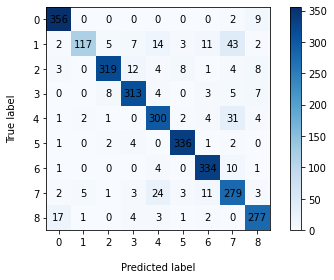

In [116]:
lr_ginza_a = LogisticRegression()  #ginza A mode
lr_ginza_a_res = train_and_test_model(lr_ginza_a, x_train_ginza_a, x_test_ginza_a, y_train_ginza_a, y_test_ginza_a)

acc:  0.8948082796063793
macro recall:  0.8805554415122354
macro precision:  0.8975323437169264


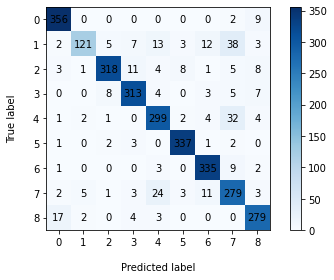

In [118]:
lr_ginza_b = LogisticRegression()  #ginza B mode
lr_ginza_b_res = train_and_test_model(lr_ginza_b, x_train_ginza_b, x_test_ginza_b, y_train_ginza_b, y_test_ginza_b)

acc:  0.8954869358669834
macro recall:  0.8808777650928713
macro precision:  0.8985790124024263


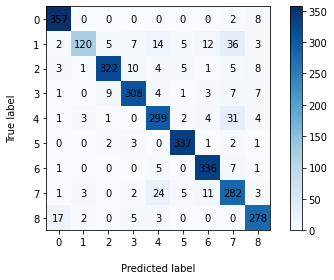

In [119]:
lr_ginza_c = LogisticRegression()  #ginza C mode
lr_ginza_c_res = train_and_test_model(lr_ginza_c, x_train_ginza_c, x_test_ginza_c, y_train_ginza_c, y_test_ginza_c)

acc:  0.8948082796063793
macro recall:  0.8794251297400563
macro precision:  0.9007542277750663


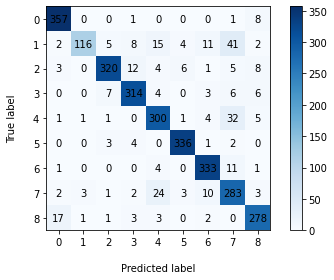

In [120]:
lr_mecab = LogisticRegression()  
lr_mecab_res = train_and_test_model(lr_mecab, x_train_mecab, x_test_mecab, y_train_mecab, y_test_mecab)

acc:  0.8954869358669834
macro recall:  0.8804651395320345
macro precision:  0.9005744535780243


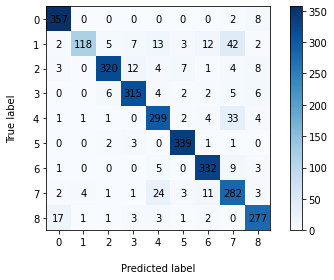

In [121]:
lr_sudachi_a = LogisticRegression()  
lr_sudachi_a_res = train_and_test_model(lr_sudachi_a, x_train_sudachi_a, x_test_sudachi_a, y_train_sudachi_a, y_test_sudachi_a)

acc:  0.8968442483881914
macro recall:  0.8823360564105974
macro precision:  0.9005304167408335


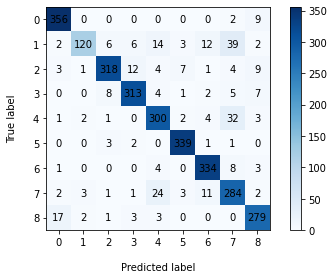

In [122]:
lr_sudachi_b = LogisticRegression()  
lr_sudachi_b_res = train_and_test_model(lr_sudachi_b, x_train_sudachi_b, x_test_sudachi_b, y_train_sudachi_b, y_test_sudachi_b)

acc:  0.9005768578215134
macro recall:  0.8860553394551808
macro precision:  0.9040542759236951


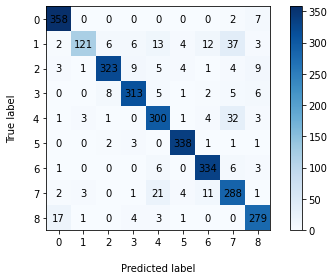

In [123]:
lr_sudachi_c = LogisticRegression()  
lr_sudachi_c_res = train_and_test_model(lr_sudachi_c, x_train_sudachi_c, x_test_sudachi_c, y_train_sudachi_c, y_test_sudachi_c)

acc:  0.9046487953851374
macro recall:  0.8913521594927061
macro precision:  0.9092178460421958


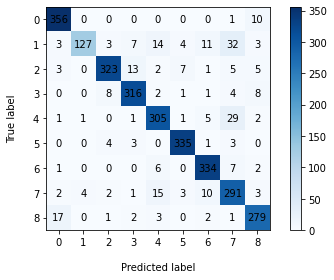

In [124]:
lr_janome = LogisticRegression()  
lr_janome_res = train_and_test_model(lr_janome, x_train_janome, x_test_janome, y_train_janome, y_test_janome)

In [128]:
lr_list = [lr_ginza_a_res,lr_ginza_b_res,lr_ginza_c_res,lr_mecab_res,lr_sudachi_a_res,lr_sudachi_b_res,lr_sudachi_c_res,lr_janome_res]
res_row_names = row_names = {0: 'ginza_a', 1: 'ginza_b', 2: 'ginza_c', 3: 'mecab', 4: 'sudachi_a', 5: 'sudachi_b', 6: 'sudachi_c', 7: 'janome'}
lr_res_list = pd.DataFrame.from_dict(lr_list).rename(res_row_names)
lr_res_list

,acc,recall,precision
ginza_a,0.892772,0.877641,0.896880
ginza_b,0.894808,0.880555,0.897532
ginza_c,0.895487,0.880878,0.898579
mecab,0.894808,0.879425,0.900754
sudachi_a,0.895487,0.880465,0.900574
sudachi_b,0.896844,0.882336,0.900530
sudachi_c,0.900577,0.886055,0.904054
janome,0.904649,0.891352,0.909218


##Random Forest

In [149]:
from sklearn.ensemble import RandomForestClassifier

acc:  0.9114353579911775
macro recall:  0.8937369936643592
macro precision:  0.918274769064388


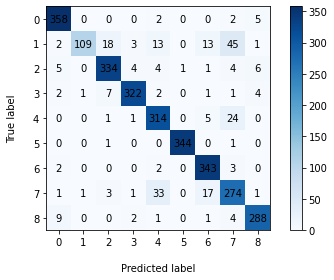

In [150]:
rf_ginza_a = RandomForestClassifier()
rf_ginza_a_res = train_and_test_model(rf_ginza_a, x_train_ginza_a, x_test_ginza_a, y_train_ginza_a, y_test_ginza_a)

acc:  0.9087207329487614
macro recall:  0.8898145816866191
macro precision:  0.9151586431342071


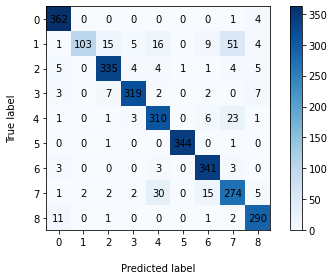

In [151]:
rf_ginza_b = RandomForestClassifier()
rf_ginza_b_res = train_and_test_model(rf_ginza_b, x_train_ginza_b, x_test_ginza_b, y_train_ginza_b, y_test_ginza_b)

acc:  0.9117746861214795
macro recall:  0.892296364205198
macro precision:  0.9189396094516622


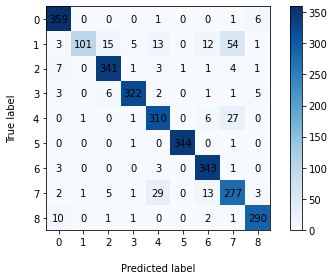

In [152]:
rf_ginza_c = RandomForestClassifier()
rf_ginza_c_res = train_and_test_model(rf_ginza_c, x_train_ginza_c, x_test_ginza_c, y_train_ginza_c, y_test_ginza_c)

acc:  0.9104173736002714
macro recall:  0.8920921416968223
macro precision:  0.9142291871063892


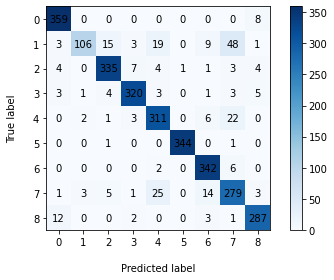

In [153]:
rf_mecab = RandomForestClassifier()  
rf_mecab_res = train_and_test_model(rf_mecab, x_train_mecab, x_test_mecab, y_train_mecab, y_test_mecab)

acc:  0.9114353579911775
macro recall:  0.8929707948518382
macro precision:  0.9162528564537565


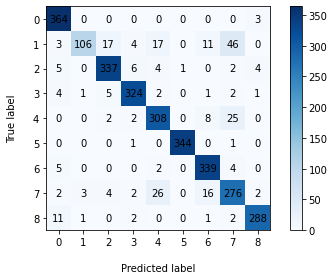

In [154]:
rf_sudachi_a = RandomForestClassifier()  
rf_sudachi_a_res = train_and_test_model(rf_sudachi_a, x_train_sudachi_a, x_test_sudachi_a, y_train_sudachi_a, y_test_sudachi_a)

acc:  0.9141499830335935
macro recall:  0.8948889181190967
macro precision:  0.920697707923672


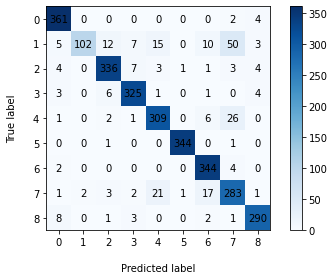

In [155]:
rf_sudachi_b = RandomForestClassifier()  
rf_sudachi_b_res = train_and_test_model(rf_sudachi_b, x_train_sudachi_b, x_test_sudachi_b, y_train_sudachi_b, y_test_sudachi_b)

acc:  0.9144893111638955
macro recall:  0.8973830412673579
macro precision:  0.920527617482178


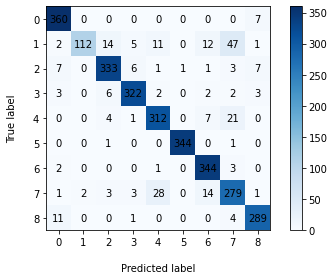

In [156]:
rf_sudachi_c = RandomForestClassifier()  
rf_sudachi_c_res = train_and_test_model(rf_sudachi_c, x_train_sudachi_c, x_test_sudachi_c, y_train_sudachi_c, y_test_sudachi_c)

acc:  0.9165252799457075
macro recall:  0.8986227216278837
macro precision:  0.9218369556879185


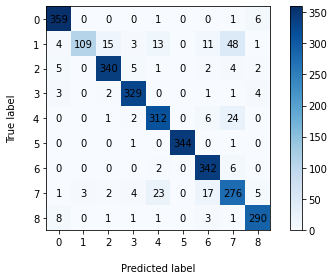

In [157]:
rf_janome = RandomForestClassifier()  
rf_janome_res = train_and_test_model(rf_janome, x_train_janome, x_test_janome, y_train_janome, y_test_janome)

In [166]:
rf_list = [rf_ginza_a_res,rf_ginza_b_res,rf_ginza_c_res,rf_mecab_res,rf_sudachi_a_res,rf_sudachi_b_res,rf_sudachi_c_res,rf_janome_res]
res_row_names = row_names = {0: 'ginza_a', 1: 'ginza_b', 2: 'ginza_c', 3: 'mecab', 4: 'sudachi_a', 5: 'sudachi_b', 6: 'sudachi_c', 7: 'janome'}
rf_res_list = pd.DataFrame.from_dict(rf_list).rename(res_row_names)
rf_res_list

,acc,recall,precision
ginza_a,0.911435,0.893737,0.918275
ginza_b,0.908721,0.889815,0.915159
ginza_c,0.911775,0.892296,0.918940
mecab,0.910417,0.892092,0.914229
sudachi_a,0.911435,0.892971,0.916253
sudachi_b,0.914150,0.894889,0.920698
sudachi_c,0.914489,0.897383,0.920528
janome,0.916525,0.898623,0.921837


acc:  0.9110960298608755
macro recall:  0.8914709720751299
macro precision:  0.9192189820560307


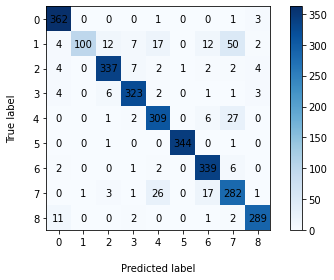

In [158]:
rf_oob_ginza_a = RandomForestClassifier(oob_score=True) #with oob
rf_oob_ginza_a_res = train_and_test_model(rf_oob_ginza_a, x_train_ginza_a, x_test_ginza_a, y_train_ginza_a, y_test_ginza_a)

acc:  0.9121140142517815
macro recall:  0.8937095415711546
macro precision:  0.9180004084729902


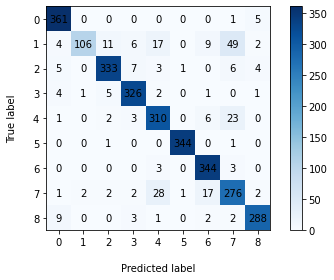

In [159]:
rf_oob_ginza_b = RandomForestClassifier(oob_score=True) #with oob
rf_oob_ginza_b_res = train_and_test_model(rf_oob_ginza_b, x_train_ginza_b, x_test_ginza_b, y_train_ginza_b, y_test_ginza_b)

acc:  0.9073634204275535
macro recall:  0.8883169686564093
macro precision:  0.9160254524680577


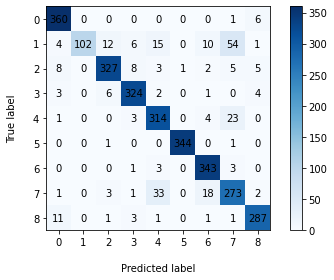

In [160]:
rf_oob_ginza_c = RandomForestClassifier(oob_score=True) #with oob
rf_oob_ginza_c_res = train_and_test_model(rf_oob_ginza_c, x_train_ginza_c, x_test_ginza_c, y_train_ginza_c, y_test_ginza_c)

acc:  0.9117746861214795
macro recall:  0.8935748757649742
macro precision:  0.9181751433138479


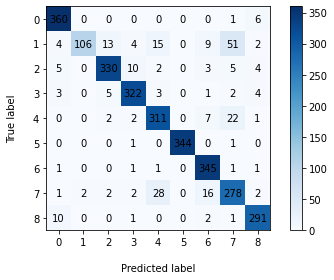

In [161]:
rf_oob_mecab = RandomForestClassifier(oob_score=True)  
rf_oob_mecab_res = train_and_test_model(rf_oob_mecab, x_train_mecab, x_test_mecab, y_train_mecab, y_test_mecab)

acc:  0.9165252799457075
macro recall:  0.8982794365822004
macro precision:  0.9238803279538642


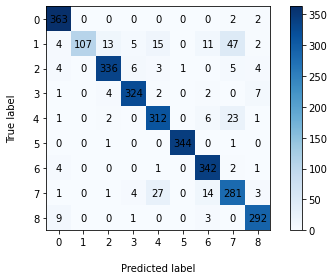

In [162]:
rf_oob_sudachi_a = RandomForestClassifier(oob_score=True)  
rf_oob_sudachi_a_res = train_and_test_model(rf_oob_sudachi_a, x_train_sudachi_a, x_test_sudachi_a, y_train_sudachi_a, y_test_sudachi_a)

acc:  0.9080420766881574
macro recall:  0.8905239099667779
macro precision:  0.9153348266593156


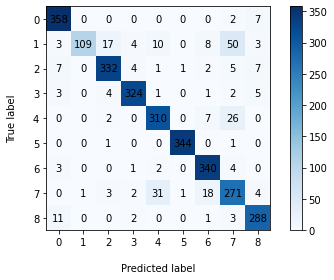

In [163]:
rf_oob_sudachi_b = RandomForestClassifier(oob_score=True)  
rf_oob_sudachi_b_res = train_and_test_model(rf_oob_sudachi_b, x_train_sudachi_b, x_test_sudachi_b, y_train_sudachi_b, y_test_sudachi_b)

acc:  0.9158466236851035
macro recall:  0.8979808806531848
macro precision:  0.9228548395432689


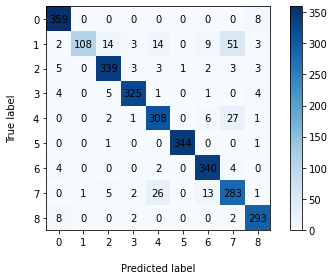

In [164]:
rf_oob_sudachi_c = RandomForestClassifier(oob_score=True)  
rf_oob_sudachi_c_res = train_and_test_model(rf_oob_sudachi_c, x_train_sudachi_c, x_test_sudachi_c, y_train_sudachi_c, y_test_sudachi_c)

acc:  0.9144893111638955
macro recall:  0.8966236651006206
macro precision:  0.9224865138988023


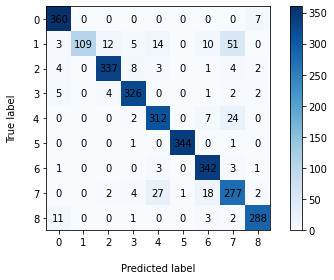

In [165]:
rf_oob_janome = RandomForestClassifier(oob_score=True)  
rf_oob_janome_res = train_and_test_model(rf_oob_janome, x_train_janome, x_test_janome, y_train_janome, y_test_janome)

In [167]:
rf_oob_list = [rf_oob_ginza_a_res,rf_oob_ginza_b_res,rf_oob_ginza_c_res,rf_oob_mecab_res,rf_oob_sudachi_a_res,rf_oob_sudachi_b_res,rf_oob_sudachi_c_res,rf_oob_janome_res]
res_row_names = row_names = {0: 'ginza_a', 1: 'ginza_b', 2: 'ginza_c', 3: 'mecab', 4: 'sudachi_a', 5: 'sudachi_b', 6: 'sudachi_c', 7: 'janome'}
rf_oob_res_list = pd.DataFrame.from_dict(rf_oob_list).rename(res_row_names)
rf_oob_res_list

,acc,recall,precision
ginza_a,0.911096,0.891471,0.919219
ginza_b,0.912114,0.893710,0.918000
ginza_c,0.907363,0.888317,0.916025
mecab,0.911775,0.893575,0.918175
sudachi_a,0.916525,0.898279,0.923880
sudachi_b,0.908042,0.890524,0.915335
sudachi_c,0.915847,0.897981,0.922855
janome,0.914489,0.896624,0.922487


##SVM 

In [168]:
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_validate

In [169]:
#svm_clf_ginza_a = LinearSVC() #Linear Kernel
#svm_clf = SVC() #RFB Kernel
cv = 10
scoring = ('accuracy','recall_macro','precision_macro')

In [170]:
svm_ginza_a = LinearSVC()

svm_ginza_a_res = cross_validate(svm_ginza_a, vectors_ginza_a, y_ginza_a, cv = cv, scoring = scoring)
svm_ginza_a_res = {'acc':(sum(svm_ginza_a_res['test_accuracy'])/10), 'recall':(sum(svm_ginza_a_res['test_recall_macro'])/10),'precision': (sum(svm_ginza_a_res['test_precision_macro'])/10) }
svm_ginza_a_res

{'acc': 0.9315858946374844,
 'recall': 0.925451406900532,
 'precision': 0.9312189440208958}

In [171]:
svm_ginza_b = LinearSVC()

svm_ginza_b_res = cross_validate(svm_ginza_b, vectors_ginza_b, y_ginza_b, cv = cv, scoring = scoring)
svm_ginza_b_res = {'acc':(sum(svm_ginza_b_res['test_accuracy'])/10), 'recall':(sum(svm_ginza_b_res['test_recall_macro'])/10),'precision': (sum(svm_ginza_b_res['test_precision_macro'])/10) }
svm_ginza_b_res

{'acc': 0.9328065084655772,
 'recall': 0.9268232554868716,
 'precision': 0.9326567818701103}

In [172]:
svm_ginza_c = LinearSVC()

svm_ginza_c_res = cross_validate(svm_ginza_c, vectors_ginza_c, y_ginza_c, cv = cv, scoring = scoring)
svm_ginza_c_res = {'acc':(sum(svm_ginza_c_res['test_accuracy'])/10), 'recall':(sum(svm_ginza_c_res['test_recall_macro'])/10),'precision': (sum(svm_ginza_c_res['test_precision_macro'])/10) }
svm_ginza_c_res

{'acc': 0.9334860406465696,
 'recall': 0.9274560430941234,
 'precision': 0.9333987774412863}

In [174]:
svm_mecab = LinearSVC()

svm_mecab_res = cross_validate(svm_mecab, vectors_mecab, y_mecab, cv = cv, scoring = scoring)
svm_mecab_res = {'acc':(sum(svm_mecab_res['test_accuracy'])/10), 'recall':(sum(svm_mecab_res['test_recall_macro'])/10),'precision': (sum(svm_mecab_res['test_precision_macro'])/10) }
svm_mecab_res

{'acc': 0.9329429310955106,
 'recall': 0.9267148625557828,
 'precision': 0.9323584663666933}

In [175]:
svm_sudachi_a = LinearSVC()

svm_sudachi_a_res = cross_validate(svm_sudachi_a, vectors_sudachi_a, y_sudachi_a, cv = cv, scoring = scoring)
svm_sudachi_a_res = {'acc':(sum(svm_sudachi_a_res['test_accuracy'])/10), 'recall':(sum(svm_sudachi_a_res['test_recall_macro'])/10),'precision': (sum(svm_sudachi_a_res['test_precision_macro'])/10) }
svm_sudachi_a_res

{'acc': 0.9363365361925549,
 'recall': 0.9302413622220375,
 'precision': 0.9354820326740073}

In [176]:
svm_sudachi_b = LinearSVC()

svm_sudachi_b_res = cross_validate(svm_sudachi_b, vectors_sudachi_b, y_sudachi_b, cv = cv, scoring = scoring)
svm_sudachi_b_res = {'acc':(sum(svm_sudachi_b_res['test_accuracy'])/10), 'recall':(sum(svm_sudachi_b_res['test_recall_macro'])/10),'precision': (sum(svm_sudachi_b_res['test_precision_macro'])/10) }
svm_sudachi_b_res

{'acc': 0.9366073535484633,
 'recall': 0.9302921405824842,
 'precision': 0.9359751040199471}

In [177]:
svm_sudachi_c = LinearSVC()

svm_sudachi_c_res = cross_validate(svm_sudachi_c, vectors_sudachi_c, y_sudachi_c, cv = cv, scoring = scoring)
svm_sudachi_c_res = {'acc':(sum(svm_sudachi_c_res['test_accuracy'])/10), 'recall':(sum(svm_sudachi_c_res['test_recall_macro'])/10),'precision': (sum(svm_sudachi_c_res['test_precision_macro'])/10) }
svm_sudachi_c_res

{'acc': 0.9378298109256091,
 'recall': 0.931958951468834,
 'precision': 0.9371410326626941}

In [179]:
svm_janome = LinearSVC()

svm_janome_res = cross_validate(svm_janome, vectors_janome, y_janome, cv = cv, scoring = scoring)
svm_janome_res = {'acc':(sum(svm_janome_res['test_accuracy'])/10), 'recall':(sum(svm_janome_res['test_recall_macro'])/10),'precision': (sum(svm_janome_res['test_precision_macro'])/10) }
svm_janome_res

{'acc': 0.939594824789098,
 'recall': 0.9340330927441954,
 'precision': 0.9386777797552966}

In [180]:
svm_list = [svm_ginza_a_res,svm_ginza_b_res,svm_ginza_c_res,svm_mecab_res,svm_sudachi_a_res,svm_sudachi_b_res,svm_sudachi_c_res,svm_janome_res]
res_row_names = row_names = {0: 'ginza_a', 1: 'ginza_b', 2: 'ginza_c', 3: 'mecab', 4: 'sudachi_a', 5: 'sudachi_b', 6: 'sudachi_c', 7: 'janome'}
svm_res_list = pd.DataFrame.from_dict(svm_list).rename(res_row_names)
svm_res_list

,acc,recall,precision
ginza_a,0.931586,0.925451,0.931219
ginza_b,0.932807,0.926823,0.932657
ginza_c,0.933486,0.927456,0.933399
mecab,0.932943,0.926715,0.932358
sudachi_a,0.936337,0.930241,0.935482
sudachi_b,0.936607,0.930292,0.935975
sudachi_c,0.937830,0.931959,0.937141
janome,0.939595,0.934033,0.938678
